**Description**: MNRL requires pretty aggressive de-duplication during batch sampling.
W/o it, the labels would be incorrect. With MPNRL, we can use default batch sampling and
then group anchors in the collator. As a result, batch sizes are much more stable. Let's
demo the data loaders on the first 10k triplets in AllNLI.

In [1]:
from datetime import datetime
from typing import Any

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.training_args import BatchSamplers
from tqdm.auto import tqdm

from mpnrl.collator import MPNRLDataCollator
from mpnrl.loss import MultiplePositivesNegativesRankingLoss

In [2]:
sns.set_theme(style="darkgrid")

# Load model and data

In [3]:
BATCH_SIZE = 200

In [4]:
model_name = "distilroberta-base"

num_train_epochs = 1

# Save path of the model
output_dir = f"output/sigltt_nli_{model_name.replace('/', '-')}-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

In [5]:
# 1. Here we define our SentenceTransformer model. If not already a Sentence Transformer model, it will automatically
# create one with "mean" pooling.
model = SentenceTransformer(model_name)
# If we want, we can limit the maximum sequence length for the model
# model.max_seq_length = 75

No sentence-transformers model found with name distilroberta-base. Creating a new one with mean pooling.


In [6]:
# 2. Load the AllNLI dataset:
#    https://huggingface.co/datasets/sentence-transformers/all-nli
dataset_name = "sentence-transformers/all-nli"
train_dataset = load_dataset(dataset_name, name="triplet", split="train")

# Subsample
n = 10_000
indices = range(n)
# You'll get nearly identical results my randomly subsampling
# generator = np.random.default_rng(seed=42)
# indices = generator.choice(n, size=n, replace=False)

train_dataset = train_dataset.select(indices)

# Utils

In [7]:
def dry_run(trainer: SentenceTransformerTrainer) -> list[dict[str, Any]]:
    num_batches = len(trainer.train_dataset) // trainer.args.train_batch_size
    data = []
    # IIUC, the trainer doesn't fully exhaust the dataloader iterator; it stops when
    # num_batches is hit. Let's replicate this behavior.
    dataloader = zip(
        range(num_batches),
        map(trainer.collect_features, trainer.get_train_dataloader()),
    )
    for _, (sentence_features, labels) in tqdm(dataloader, total=num_batches):
        batch_data = {}
        features_anchor, features_candidates = (
            sentence_features[0],
            sentence_features[1:],
        )
        batch_data["num_anchors"] = features_anchor["input_ids"].shape[0]
        batch_data["num_candidates"] = sum(
            features["input_ids"].shape[0] for features in features_candidates
        )
        if labels is not None:
            batch_data["num_positives_per_anchor"] = [
                len(indices) for indices in labels
            ]
        data.append(batch_data)
    return data

In [8]:
def plot(
    batch_data: list[dict[str, Any]], batch_size: int, title: str = ""
) -> plt.Axes:
    df = (
        pl.DataFrame(batch_data)
        .with_columns(pl.Series("batch", range(1, len(batch_data) + 1)))
        .rename({"num_anchors": "anchors", "num_candidates": "candidates"})
    )
    melted_df = df.unpivot(
        index=["batch"],
        on=["anchors", "candidates"],
        variable_name="Type",
        value_name="Value",
    )
    ax = sns.lineplot(data=melted_df, x="batch", y="Value", hue="Type")
    ax.axhline(y=batch_size, color="k", linestyle="--", label="inputted batch size")
    ax.set_ylabel("# observations")
    ax.set_title(title)
    ax.legend()
    return ax

# MNRL dataloader

In [9]:
dummy_trainer_mnrl = SentenceTransformerTrainer(
    model=model,
    args=SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir=output_dir,
        # Optional training parameters:
        use_mps_device=False,
        num_train_epochs=1,
        per_device_train_batch_size=BATCH_SIZE,
        batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
        seed=42,
    ),
    train_dataset=train_dataset,
    loss=losses.MultipleNegativesRankingLoss(model),
    data_collator=None,
)

In [10]:
batch_data_mnrl = dry_run(dummy_trainer_mnrl)

  0%|          | 0/50 [00:00<?, ?it/s]

# MPNRL dataloader

In [11]:
dummy_trainer_mpnrl = SentenceTransformerTrainer(
    model=model,
    args=SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir=output_dir,
        # Optional training parameters:
        use_mps_device=False,
        num_train_epochs=1,
        per_device_train_batch_size=BATCH_SIZE,
        batch_sampler=BatchSamplers.BATCH_SAMPLER,
        seed=42,
    ),
    train_dataset=train_dataset,
    loss=MultiplePositivesNegativesRankingLoss(model),
    data_collator=MPNRLDataCollator(train_dataset, tokenize_fn=model.tokenize),
)

In [12]:
batch_data_mpnrl = dry_run(dummy_trainer_mpnrl)

  0%|          | 0/50 [00:00<?, ?it/s]

# Numbers

MNRL:

In [13]:
sum(batch_data["num_anchors"] for batch_data in batch_data_mnrl)

2324

In [14]:
sum(batch_data["num_candidates"] for batch_data in batch_data_mnrl)

4648

The dataloader for MNRL didn't process all of the inputted training data b/c it stops
after `num_batches` steps.

MPNRL:

In [15]:
sum(batch_data["num_anchors"] for batch_data in batch_data_mpnrl)

2029

In [16]:
sum(batch_data["num_candidates"] for batch_data in batch_data_mpnrl)

13968

# Plots

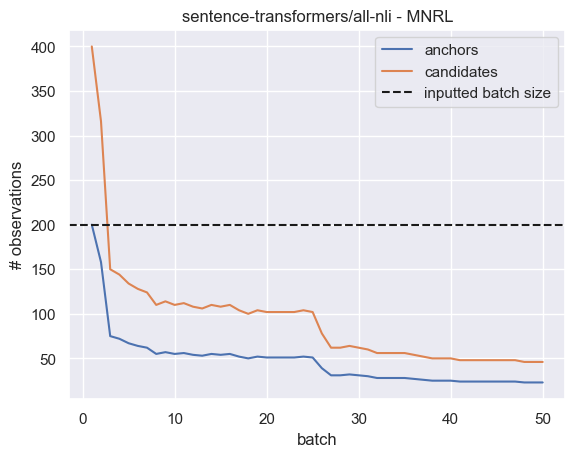

In [17]:
_ = plot(batch_data_mnrl, BATCH_SIZE, title=f"{dataset_name} - MNRL")

The sizes decay b/c of no-duplicates sampling. The first batch can likely find as many
anchors as the batch size. But this just leaves duplicates for future iterations. I
wonder if there's some formula for calculating the expected number of anchors and
candidates from no-duplicates sampling given an average for the number of candidates per
anchor.

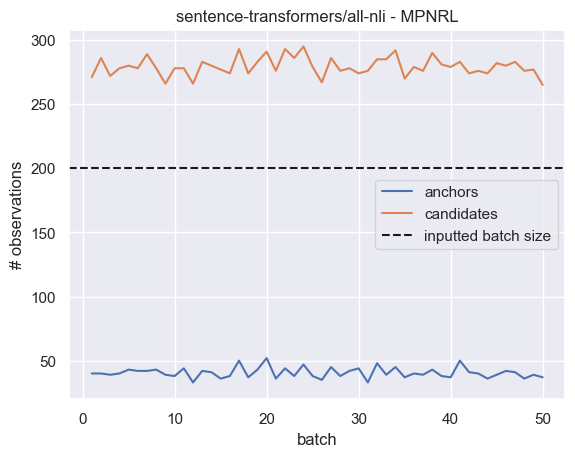

In [18]:
_ = plot(batch_data_mpnrl, BATCH_SIZE, title=f"{dataset_name} - MPNRL")

The number of anchors doesn't hit the inputted batch size b/c the batch sampler picks up
duplicates and then groups them.